In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import networkx as nx
import plotly
import simplejson as json

In [8]:
import collections

In [9]:
from networkx.readwrite import json_graph

In [10]:
plotly.tools.set_credentials_file(username='xtinabog', api_key='iaoraswcyb')

In [11]:
from src.main import parseGML
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
import plotly.plotly as py
from plotly.graph_objs import *

In [13]:
from src.main import getD3Json

In [14]:
def get_rt_count(G):
    counts = {}
    for edge in G.edges():
        weight = G.get_edge_data(edge[0],edge[1])['weight']
        for user in edge:
            if user in counts.keys():
                counts[user] += int(weight)
            else:
                counts[user]=int(weight)
    return {k:int(v) for k,v in counts.iteritems()}

In [16]:
cooccurences, coRU, coUK, names = parseGML('/Users/sablayra/Capstone/rtnets_ukru_20131125_20140228.gml/rt_2014_2_19.langfilt.gml')
# parseGML('/scratch/nyu/capstone/gmls/rt_2014_2_19.langfilt.gml')
cooccurences = cooccurences.toarray()
names = np.array(names)

Number of nodes who have more than 500 retweeters: 19
82964.0
(36798,)
(36798,)


In [106]:
G = nx.Graph()
for i in range(cooccurences.shape[0]):
    topX = np.argsort(cooccurences[i,:])[-5:]
    for j in topX:
        G.add_edge(names[i], names[j], weight=cooccurences[i][j])

In [108]:
tweet_counts = get_rt_count(G)
nx.set_node_attributes(G,'rts',tweet_counts)
json_g = json_graph.node_link_data(G)
json.dump(json_g,open('./viz/dump/graph_5.json','w'))

---------------
Visualizing in Plotly

In [90]:
def scatter_nodes(pos, labels=None, color=None, size=20, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    #opacity is a value between [0,1] defining the node color opacity
    L=len(pos)
    trace = Scatter(x=[], y=[],  mode='markers', marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='Jet',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))
    for k,a in zip(pos.keys(),G.adjacency_list()):
        
        trace['x'].append(pos[k][0])
        trace['y'].append(pos[k][1])
        trace['marker']['color'].append(color[k])
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size
    return trace    

In [37]:
def scatter_edges(G, pos, line_color=None, line_width=1):
    trace = Scatter(x=[], y=[], mode='lines')
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        data = G.get_edge_data(edge[0],edge[1])
        #print data['weight']
        trace['line']['color']=G.get_edge_data(edge[0],edge[1])
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace            

In [38]:
labels=[str(k)  for k in range(len(pos))] # labels are  set as being the nodes indices in the list of nodes
trace1=scatter_edges(G, pos)
trace2=scatter_nodes(pos, labels=pos.keys(),color=node_edges)

In [39]:
width=600
height=600
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= '2.19.2014 RT-Network',  #
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=XAxis(axis),
    yaxis=YAxis(axis),
    margin=Margin(
        l=30,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])

fig = Figure(data=data, layout=layout)

In [40]:
def make_annotations(pos, text, font_size=14, font_color='rgb(25,25,25)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = Annotations()
    for i,k in enumerate(pos.keys()):
        annotations.append(
            Annotation(
                text=i, 
                x=pos[k][0], y=pos[k][1],
                xref='x1', yref='y1',
                font=dict(color= font_color, size=font_size),
                showarrow=False)
        )
    return annotations  

In [41]:
fig['layout'].update(annotations=make_annotations(pos, pos.keys()))  
#py.sign_in('', '')
py.iplot(fig, filename='tst')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~xtinabog/0 or inside your plot.ly account where it is named 'tst'


In [20]:
pos=nx.get_node_attributes(G,'pos')

In [16]:
edge_trace = Scatter(
    x=[], 
    y=[], 
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[], 
    y=[], 
    text=[],
    mode='markers', 
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

KeyError: 'pos'

In [13]:
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

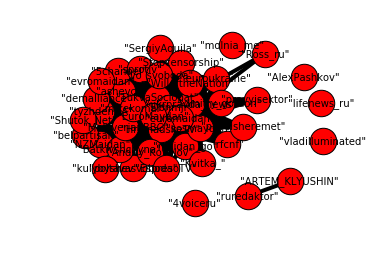

In [23]:
nx.draw_networkx_nodes(G,pos,node_size=700)
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 100]
esmall=[]

nx.draw_networkx_edges(G,pos,edgelist=elarge, width=4)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=4, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')
plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display